In [163]:
import pandas as pd
import numpy as np
import nltk
import os
import unicodedata
#import contractions
#import textract
#import gensim -- doesn't work
import spacy
import re
import string
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 150)
pd.set_option("display.precision", 3)
from itertools import cycle
from collections import defaultdict

from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
import scattertext as st
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("words")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

from textblob import TextBlob, Word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from wordcloud import WordCloud, STOPWORDS


[nltk_data] Downloading package punkt to /Users/Dubya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Dubya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/Dubya/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Dubya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Dubya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Goal and Context 
Using NLP let's explore modern comedy and the topics they cover.  Comedy is an outlet that on the surface level is to entertain and make us laugh when at its best.  On a deeper level, it explores the topics and ideas that we don't always say outloud and explore different aspects of our culture.  I think it's an interesting problem for NLP given the layers within comedy including sarcasm, symbolism and metaphorical stories. 

I also want to explore deeper the topics of male and female comedy. 

In [2]:
comedy = pd.read_csv('Comedy.csv')
comedy

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text
0,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,1,"Thank you. Thank you, thank you. Oh yeah. Oh y..."
1,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,2,One thing I'm seeing. Ever be walking down the...
2,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,3,The black people are very afraid of the police...
3,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,4,But I didn't always know. It was a black thing...
4,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,5,A black man would never dream of talking to th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,58,"‘Cause, look, whatever you’re into, okay? ‘Cau..."
1381,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,59,"So whatever your thing is, I don’t know what i..."
1382,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,60,As far as my thing — I dunno what the fuck… Pe...
1383,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,61,Let me ask you a question. You ever wonder how...


###  Dataframe Detail

This data frame includes over 30 comedy specials from 20 stand up comedians.  Most of the material is from the last 5 years to get an idea of where modern comedy is at (and from what data was available especially given 2020 was low for stand up due to the pandemic).  The comedian list is split 50-50 between men and women and the gender is identified per the best guess at the self identification of the artist gender found online.

Included as a proxy of viewership, I've included IMDB ratings and view count in total and also split by gender to get an idea of how the comedy is received overall and by gender.  

Each special is broken down into shorter documents of 100-300 words as given by the flow of the special to allow for a closer look at the topics discussed throughout the sepcials.

### EDA

In [3]:
len(comedy["Title"].unique())

31

In [4]:
len(comedy["Comedian"].unique())

18

In [5]:
female = comedy[comedy["Comedian_Gender"] == "F"]

In [6]:
female = female.drop_duplicates(subset = ["Comedian"])
female

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text
323,2012,Mostly Sex Stuff,Amy Schumer,"New York, NY",F,5.8,7.0,2903,7.1,5.7,478,1709,1,"Fuck, yeah! This is such a big night for you. ..."
462,2018,Hard Knock Wife,Ali Wong,"Toronto, ON",F,7.4,8.0,4074,7.6,7.1,1232,1705,1,"Oh, my goodness! I heard a rumor that all of t..."
533,2013,We Are Miracles,Sarah Silverman,"Los Angeles, CA",F,6.7,7.0,1311,7.0,6.6,151,967,1,"Hey, I like your knee socks. They're not knee ..."
603,2019,Not Normal,Wanda Sykes,"New York, NY",F,7.2,7.0,1591,7.6,6.0,447,727,1,"Yes. Yes. Thank you. New York. New York. Oh, m..."
771,2019,I Be Knowin',Amanda Seales,"New York, NY",F,6.1,7.0,307,7.7,5.3,86,139,1,We did it. We here. My people. Ah! The real on...
877,2019,Ice Thickeners,Emily Heller,"Seattle, WA",F,7.4,7.5,17,8.7,7.3,3,11,1,"Oh my God, oh, thank you so much. Oh! Seattle,..."
1145,2018,Relatable,Ellen Degeneres,"Seattle, WA",F,6.5,7.0,4409,6.7,6.3,1317,1920,1,"Thank you so much for being here, Seattle. So ..."
1197,2019,Unveiled,Iliza Shlesinger,"Nashville, TN",F,6.5,7.0,1400,6.9,6.2,384,662,1,"Thank you, Nashville! Thank you. So this year ..."
1264,2020,Douglas,Hannah Gadsby,"Los Angeles, CA",F,7.9,8.0,3092,8.3,7.4,937,1290,1,Look at this! Look at this. That… That is a do...


### Text Cleaning

In [7]:
#List of all english words in nltk
words = set(nltk.corpus.words.words())
len(words)

235892

Make sure all words are lower in nltk if we need to use/check later on

In [8]:
words = [word.lower() for word in words]

Clean text by taking out spaces for end of paragraphs, replacing quotes within the text, getting rid of elliptaking care of alpha numeric characters and addressing punctation.  We will look at stop words and them lemmitization and stemming as next steps

In [9]:
uni = lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf8')
breaks = lambda x: re.sub("\n", " ", x)
dub = lambda x: x.replace('“', '')
elip = lambda x: x.replace('...', '')
quotes = lambda x:  x.replace("'", "")
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())

In [10]:
comedy["Text"] = comedy["Text"].map(breaks).map(quotes).map(dub).map(alphanumeric).map(punc_lower).map(elip)

In [11]:
comedy

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text
0,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,1,thank you thank you thank you oh yeah oh yeah ...
1,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,2,one thing im seeing ever be walking down the s...
2,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,3,the black people are very afraid of the police...
3,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,4,but i didnt always know it was a black thing i...
4,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,5,a black man would never dream of talking to th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,58,‘cause look whatever you’re into okay ‘cause e...
1381,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,59,so whatever your thing is i don’t know what it...
1382,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,60,as far as my thing — i dunno what the fuck… pe...
1383,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,61,let me ask you a question you ever wonder how ...


Let's take a look at first few paragraphs to see how our text currently looks

In [12]:
for text in comedy["Text"][0:20]:
    print(text)

thank you thank you thank you oh yeah oh yeah all right no really boy well its good to come home boy i swear i know man its been a while its been a while hey dc is different ive been gone man it took me years to be able to do the show boy dc has changed its different now theres a lot of white people walking around isnt there i mean i left dc in the  it was not like this in the  when crack was going on remember when crack was going on white people would be looking at dc from virginia with binoculars boy that looks dangerous not yet new white people you cant scare these white people i tried you roll up on em boo what the hell is wrong with you those days are over im glad that were doing a show here by howard you know you see like white people come out and thats good  
one thing im seeing ever be walking down the street and you see like a group of black dudes walking not just any black dudes were talking you know thugs talking you know theyll be some thugs man and in the group in the grou

### Stop Words

In [13]:
com_stop_words = nltk.corpus.stopwords.words('english')
print(com_stop_words)
type(com_stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

list

Nothing that I want to add to stop words off the bat.  I will be looking at laughing and chuckling as some of the text did have bracketed quotes with the comedians laughing at themselves.  Applauding could be looked at as well as crowd applause was also in the text between brackets as well.

Let's use the stop words and take a look at our dimension/vocabulary size for the documents

### Vectorization 

In [14]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["Text"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aaaah,aaah,aah,aaliyah,aand,abandon,abandoned,abc,abdomen,abduljabbar,abigail,ability,abject,ablazing,able,ablebodied,ableist,aboriginals,aborted,abortion,abortions,aboveground,abox,abraham,...,zelda,zero,zest,zhuzh,zigzag,zigzagging,zip,ziploc,zippitydoodah,zombie,zombies,zone,zoo,zookeeper,zoom,zoomed,zubadabadabaabala,zucker,zuckerberg,zuckerfuck,zuckerfucker,zuckermother,zuckzucker,zurich,ça
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This actually looks quite good on the oirignal data set for text, let's see if it does any better with lemmatization

### Lemmatization 

In [15]:
lemma = WordNetLemmatizer()
word_tokenizer = lambda x: word_tokenize(x)
lemmatize = lambda x: " ".join([lemma.lemmatize(w) for w in x])

In [16]:
comedy["lemmy"] = comedy["Text"].apply(word_tokenizer).apply(lemmatize)
comedy

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text,lemmy
0,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,1,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...
1,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,2,one thing im seeing ever be walking down the s...,one thing im seeing ever be walking down the s...
2,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,3,the black people are very afraid of the police...,the black people are very afraid of the police...
3,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,4,but i didnt always know it was a black thing i...,but i didnt always know it wa a black thing it...
4,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,5,a black man would never dream of talking to th...,a black man would never dream of talking to th...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,58,‘cause look whatever you’re into okay ‘cause e...,‘ cause look whatever you ’ re into okay ‘ cau...
1381,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,59,so whatever your thing is i don’t know what it...,so whatever your thing is i don ’ t know what ...
1382,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,60,as far as my thing — i dunno what the fuck… pe...,a far a my thing — i dunno what the fuck… peop...
1383,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,61,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...


In [17]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["lemmy"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aaaah,aaah,aah,aaliyah,aand,ab,abandon,abandoned,abc,abdomen,abduljabbar,abigail,ability,abject,ablazing,able,ablebodied,ableist,aboriginal,aborted,abortion,aboveground,abox,abraham,...,zeke,zelda,zero,zest,zhuzh,zigzag,zigzagging,zip,ziploc,zippitydoodah,zombie,zone,zoo,zookeeper,zoom,zoomed,zubadabadabaabala,zucker,zuckerberg,zuckerfuck,zuckerfucker,zuckermother,zuckzucker,zurich,ça
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lemmitization eliminated about 1000 words from the document.

Let's next look at stemming to see how much help it can be

### Stemming

In [18]:
stemm = PorterStemmer()
word_tokenizer = lambda x: word_tokenize(x)
stemify = lambda x: " ".join([stemm.stem(w) for w in x])

In [19]:
comedy["stemmy"] = comedy["Text"].apply(word_tokenizer).apply(stemify)
comedy

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text,lemmy,stemmy
0,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,1,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...
1,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,2,one thing im seeing ever be walking down the s...,one thing im seeing ever be walking down the s...,one thing im see ever be walk down the street ...
2,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,3,the black people are very afraid of the police...,the black people are very afraid of the police...,the black peopl are veri afraid of the polic t...
3,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,4,but i didnt always know it was a black thing i...,but i didnt always know it wa a black thing it...,but i didnt alway know it wa a black thing it ...
4,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,5,a black man would never dream of talking to th...,a black man would never dream of talking to th...,a black man would never dream of talk to the p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,58,‘cause look whatever you’re into okay ‘cause e...,‘ cause look whatever you ’ re into okay ‘ cau...,‘ caus look whatev you ’ re into okay ‘ caus e...
1381,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,59,so whatever your thing is i don’t know what it...,so whatever your thing is i don ’ t know what ...,so whatev your thing is i don ’ t know what it...
1382,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,60,as far as my thing — i dunno what the fuck… pe...,a far a my thing — i dunno what the fuck… peop...,as far as my thing — i dunno what the fuck… pe...
1383,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,61,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...


In [20]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["stemmy"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aaaah,aaah,aah,aaliyah,aand,ab,abandon,abc,abdomen,abduljabbar,abigail,abil,abject,abl,ablaz,ablebodi,ableist,aborigin,abort,abov,aboveground,abox,abraham,abroad,...,zap,zealand,zebra,zeke,zelda,zero,zest,zhuzh,zigzag,zip,ziploc,zippitydoodah,zombi,zone,zoo,zookeep,zoom,zubadabadabaabala,zucker,zuckerberg,zuckerfuck,zuckermoth,zuckzuck,zurich,ça
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Well this does help a little bit (~1000 words) but we have word that are still sound effects/non engligh as well as new words like "abov" in place for "above" which could be miss-leading.  

### NLTK to eliminate non english word/sound effects in written form

In [21]:
del_not_eng = lambda x: " ".join(w for w in nltk.word_tokenize(x) if w in words)
comedy["nltk"] = comedy["Text"].apply(del_not_eng)

In [22]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["nltk"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,abandon,abandoned,abdomen,abigail,ability,abject,able,aborted,abortion,aboveground,abox,abraham,abroad,abscess,absolute,absolutely,absolutism,absorb,absorbing,abundant,abuse,abuser,abusively,academically,...,yep,yes,yesterday,yet,yield,yo,yoga,york,youd,young,younger,youth,youve,yuck,yummy,zebra,zeke,zero,zest,zigzag,zip,zombie,zone,zoo,zoom
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Spacy 
We'll try to see if spacy can help clean up a few more items than NLTK was able to

In [23]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [24]:
doc = nlp("abandoned, abandonment, aboveground, absolute, absolutely, absolutism, absorb, absorbing, abuse, abuser, youve")
" ".join([token.lemma_ for token in doc])

'abandon , abandonment , aboveground , absolute , absolutely , absolutism , absorb , absorbing , abuse , abuser , you ve'

Not perfect at getting to root words in all cases, let's take a look and see how it compares to NLTK

In [25]:
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [26]:
comedy["spacy"] = comedy["Text"].apply(spacy_lemmatize)
comedy

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text,lemmy,stemmy,nltk,spacy
0,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,1,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...
1,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,2,one thing im seeing ever be walking down the s...,one thing im seeing ever be walking down the s...,one thing im see ever be walk down the street ...,one thing seeing ever be walking down the stre...,one thing I m see ever be walk down the street...
2,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,3,the black people are very afraid of the police...,the black people are very afraid of the police...,the black peopl are veri afraid of the polic t...,the black people are very afraid of the police...,the black people be very afraid of the police ...
3,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,4,but i didnt always know it was a black thing i...,but i didnt always know it wa a black thing it...,but i didnt alway know it wa a black thing it ...,but i didnt always know it was a black thing i...,but I do nt always know it be a black thing it...
4,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,5,a black man would never dream of talking to th...,a black man would never dream of talking to th...,a black man would never dream of talk to the p...,a black man would never dream of talking to th...,a black man would never dream of talk to the p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,58,‘cause look whatever you’re into okay ‘cause e...,‘ cause look whatever you ’ re into okay ‘ cau...,‘ caus look whatev you ’ re into okay ‘ caus e...,cause look whatever you re into cause everybod...,' cause look whatever you ’re into okay ' caus...
1381,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,59,so whatever your thing is i don’t know what it...,so whatever your thing is i don ’ t know what ...,so whatev your thing is i don ’ t know what it...,so whatever your thing is i don t know what it...,so whatever your thing be I do n’t know what i...
1382,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,60,as far as my thing — i dunno what the fuck… pe...,a far a my thing — i dunno what the fuck… peop...,as far as my thing — i dunno what the fuck… pe...,as far as my thing i what the people are like ...,as far as my thing — I dunno what the fuck … p...
1383,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,61,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...,let I ask you a question you ever wonder how m...


In [27]:
newstops = ['could','w','thank','thing','im','conve','okay','th','pe','dtype','pha','b','ugh','amy','dave','make','lot','come','let','even','yo','went','got','go','ok','ill','hey','nt','ca',"oh", "um",'thank you', 'cause','wan','wa','na','ta','gon','thats','kevin', 'theyre','cant','aint','yeah', 'would','really','get','didnt','dont']
com_stop_words.extend(newstops)

In [28]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["spacy"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,aaaah,aaah,aah,aaliyah,aand,ab,abandon,abc,abdoman,abduljabbar,abigail,ability,abject,ablaze,able,ablebodie,ablebodied,ableist,aboriginal,aborted,abortion,aboveground,abox,abraham,...,zap,zealand,zebra,zeke,zelda,zero,zhuzh,zigzag,zip,ziploc,zippitydoodah,zombie,zone,zoo,zookeeper,zoom,zubadabadabaabala,zucker,zuckerberg,zuckerfuck,zuckerfucker,zuckermother,zuckzucker,zurich,ça
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


It looks like spacy doesn't really help as we still have many sound effect words and things like "zuckerzucker".  Let's see if layering this on top of the NLTK can help in any of the areas that NLTK missed.

In [29]:
comedy["clean"] = comedy["nltk"].apply(spacy_lemmatize)
comedy

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text,lemmy,stemmy,nltk,spacy,clean
0,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,1,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...
1,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,2,one thing im seeing ever be walking down the s...,one thing im seeing ever be walking down the s...,one thing im see ever be walk down the street ...,one thing seeing ever be walking down the stre...,one thing I m see ever be walk down the street...,one thing seeing ever be walk down the street ...
2,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,3,the black people are very afraid of the police...,the black people are very afraid of the police...,the black peopl are veri afraid of the polic t...,the black people are very afraid of the police...,the black people be very afraid of the police ...,the black people be very afraid of the police ...
3,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,4,but i didnt always know it was a black thing i...,but i didnt always know it wa a black thing it...,but i didnt alway know it wa a black thing it ...,but i didnt always know it was a black thing i...,but I do nt always know it be a black thing it...,but I do nt always know it be a black thing it...
4,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,5,a black man would never dream of talking to th...,a black man would never dream of talking to th...,a black man would never dream of talk to the p...,a black man would never dream of talking to th...,a black man would never dream of talk to the p...,a black man would never dream of talk to the p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,58,‘cause look whatever you’re into okay ‘cause e...,‘ cause look whatever you ’ re into okay ‘ cau...,‘ caus look whatev you ’ re into okay ‘ caus e...,cause look whatever you re into cause everybod...,' cause look whatever you ’re into okay ' caus...,cause look whatever you re into cause everybod...
1381,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,59,so whatever your thing is i don’t know what it...,so whatever your thing is i don ’ t know what ...,so whatev your thing is i don ’ t know what it...,so whatever your thing is i don t know what it...,so whatever your thing be I do n’t know what i...,so whatever your thing be I don t know what it...
1382,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,60,as far as my thing — i dunno what the fuck… pe...,a far a my thing — i dunno what the fuck… peop...,as far as my thing — i dunno what the fuck… pe...,as far as my thing i what the people are like ...,as far as my thing — I dunno what the fuck … p...,as far as my thing I what the people be like w...
1383,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,61,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...,let I ask you a question you ever wonder how m...,let I ask you a question you ever wonder how m...


In [30]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["clean"])
pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

,aa,abandon,abdoman,abigail,ability,abject,able,abort,abortion,aboveground,abox,abraham,abroad,abscess,absolute,absolutely,absolutism,absorb,abundant,abuse,abuser,abusively,academically,academy,accent,...,yell,yelling,yellow,yelp,yep,yes,yesterday,yet,yield,yoga,york,young,youth,yuck,yummy,zebra,zeke,zero,zest,zigzag,zip,zombie,zone,zoo,zoom
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1381,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1383,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Looks like we're able to reduce about 500 additional words with spacy on top of nltk.  We will keep both of these columns and drop lemmitization and stemming parts of the dataframe

In [31]:
comedy = comedy.drop(columns=['lemmy','stemmy','spacy'])

In [32]:
comedy

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text,nltk,clean
0,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,1,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...
1,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,2,one thing im seeing ever be walking down the s...,one thing seeing ever be walking down the stre...,one thing seeing ever be walk down the street ...
2,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,3,the black people are very afraid of the police...,the black people are very afraid of the police...,the black people be very afraid of the police ...
3,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,4,but i didnt always know it was a black thing i...,but i didnt always know it was a black thing i...,but I do nt always know it be a black thing it...
4,2000,Killin' Them Softly,Dave Chappelle,Washington D.C.,M,8.8,9.0,9029,8.5,8.8,484,6434,5,a black man would never dream of talking to th...,a black man would never dream of talking to th...,a black man would never dream of talk to the p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1380,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,58,‘cause look whatever you’re into okay ‘cause e...,cause look whatever you re into cause everybod...,cause look whatever you re into cause everybod...
1381,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,59,so whatever your thing is i don’t know what it...,so whatever your thing is i don t know what it...,so whatever your thing be I don t know what it...
1382,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,60,as far as my thing — i dunno what the fuck… pe...,as far as my thing i what the people are like ...,as far as my thing I what the people be like w...
1383,2020,Sincerely,Louis CK,Washington D.C.,M,8.4,9.0,4257,8.1,8.4,203,2984,61,let me ask you a question you ever wonder how ...,let me ask you a question you ever wonder how ...,let I ask you a question you ever wonder how m...


In [33]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

It looks like we have a few comedian names to consider removing (comedians referencing themselves) as well as a few nonsensical words like ain from ain't.  Let's first take a look at a model to see if any other words stand out in our topic models ot add with items from the ScatterText plot. 

## Modeling

In this section we will start with looking at LSA and NFM using count vectorizer.  Depending on how things go we will adjust stop words/model settings to get a better idea of our topics and what tweaks can clarify things. We will then look at comparing vs TF-IDF

Let's first create a topic display function to help us get topics for models

In [37]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    Display highest weighted words for topics
    """
    for x, topic in enumerate(model.components_):
        if not topic_names or not topic_names[x]:
            print("\nTopic ", x)
        else:
            print("\nTopic: '", topic_names[x], "'")
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

### NMF

In [38]:
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, one, guy, love, girl, feel, want, kind, walk, sex

Topic  1
know, mean, want, tell, little, feel, way, look, time, good

Topic  2
say, well, tell, one, good, joke, mean, back, son, talk

Topic  3
right, one, take, tell, god, well, little, time, first, work

Topic  4
people, white, black, need, see, talk, asian, show, always, well

Topic  5
man, good, time, black, woman, feel, white, want, ass, back

Topic  6
see, look, baby, time, one, take, back, kid, talk, house

Topic  7
think, god, mean, well, never, want, feel, dick, time, person


Looks like we have a few words we need to add to our list.  Oh and Um noises from speech as well as thank as many comedidans end and start their speeches with lots of thank yous.

In [39]:
newstops = ['ugh','amy','dave','make','lot','come','let','even','yo','went','got','go','ok','ill','hey','nt','ca',"oh", "um",'thank you', 'cause','wan','wa','na','ta','gon','thats','kevin', 'theyre','cant','aint','yeah', 'would','really','get','didnt','dont']
com_stop_words.extend(newstops)

In [40]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [41]:
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, one, guy, love, girl, feel, want, kind, walk, sex

Topic  1
know, mean, want, tell, little, feel, way, look, time, good

Topic  2
say, well, tell, one, good, joke, mean, back, son, talk

Topic  3
right, one, take, tell, god, well, little, time, first, work

Topic  4
people, white, black, need, see, talk, asian, show, always, well

Topic  5
man, good, time, black, woman, feel, white, want, ass, back

Topic  6
see, look, baby, time, one, take, back, kid, talk, house

Topic  7
think, god, mean, well, never, want, feel, dick, time, person


It looks like we have a few topics that make some sense.  The first topic (Topic 0) seems to indicate things around boy, girl and feelings, so perhaps a love category.  The second one looks like a communucation or understanding between people with words like know, mean, tell and look, but probably needs a bit more refinement to confirm that intuition.

Topics 2 & 3 seem a bit ambigiuous, maybe something around children and time in top 3 but topic 2 is hard to read.

Topic 4 is also interesting in it seems to have an idea around race with white, black and asian all mentioned with people.  Let's play around with max and min df parameters

In [42]:
cv = CountVectorizer(stop_words=com_stop_words,max_df = .9,min_df=2)
doc_word = cv.fit_transform(comedy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [43]:
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, think, one, see, guy, love, look, want, feel, girl

Topic  1
know, think, mean, want, tell, little, feel, look, dog, way

Topic  2
say, one, well, tell, baby, good, back, talk, mean, son

Topic  3
right, one, god, take, well, tell, little, think, work, always

Topic  4
people, white, black, see, think, need, talk, look, asian, person

Topic  5
man, see, time, good, look, back, kid, one, want, take


Playing aroudn with various max and min features we get similar features.  Let's try playing around with n grams to see if that warrants anything

In [44]:
cv = CountVectorizer(stop_words=com_stop_words,max_df = .8,min_df=2,ngram_range=(1, 2))
doc_word = cv.fit_transform(comedy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [45]:
nmf_model = NMF(6)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
know, think, know like, like know, mean, want, know know, feel, little, tell

Topic  1
say, say say, well, tell, good, one, mean, son, joke, back

Topic  2
right, one, god, well, take, think, guy, tell, love, little

Topic  3
people, white, black, white people, black people, see, people like, think, need, talk

Topic  4
see, one, look, think, time, baby, back, good, take, want

Topic  5
man, good, black, time, woman, white, feel, kid, house, back


Looks line ngrams and binary set to true don't help the analysis much as thinks like know know and know like and like know aren't really clearing anything up.

Let's try TF-IDF to see if it brings anything to the analysis

In [46]:
cv = TfidfVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [47]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
right, man, know, time, kid, baby, take, good, look, want

Topic  1
like, know, think, one, guy, love, right, girl, feel, look

Topic  2
white, people, black, know, see, man, talk, mean, think, something

Topic  3
dog, douglas, park, name, back, shelter, baby, love, people, well

Topic  4
say, gay, know, joke, well, show, tell, talk, mean, son


Looking at using TFIDF and some of the min/max DF and n gram features, so far the basic NMF seems to have three of the cleaner topics so far as this last iteration does have topics where we could think of some decent ideas.

Topic 0  = Man and kid, and perhaps things around generation interaction, but this seems a bit of a stretch
Topic 1 = The love story we saw above
Topic 2 = maybe something closer to race and relating to different people and understanding
Topic 3 = Generally makes me happy but shelter, dogs, baby and love aren't easily contectable.  Perhaps something around home life?
Topic 4 = Really appears to be centered around communication, but also mixed in with some noises.

Let's revert back to our first model with the updated top words and take a closer look at the text related to the top few topics

In [49]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [50]:
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 10)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, one, guy, love, girl, feel, want, kind, walk, sex

Topic  1
know, mean, want, tell, little, feel, way, look, time, good

Topic  2
say, well, tell, one, good, joke, mean, back, son, talk

Topic  3
right, one, take, tell, god, well, little, time, first, work

Topic  4
people, white, black, need, see, talk, asian, show, always, well

Topic  5
man, good, time, black, woman, feel, white, want, ass, back

Topic  6
see, look, baby, time, one, take, back, kid, talk, house

Topic  7
think, god, mean, well, never, want, feel, dick, time, person


#### NMF Topic Word Exploration

In [102]:
corpus = comedy['clean'].fillna(value='')

cv = CountVectorizer(stop_words=com_stop_words)

comedy_word_matrix = cv.fit_transform(corpus)

vocab = cv.get_feature_names()

In [103]:
nmf = NMF(n_components=8)

nmf.fit(comedy_word_matrix)


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=8)

In [104]:
comedy_topic_matrix = nmf.transform(comedy_word_matrix)

In [105]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=vocab).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
aa,0.000,4.091e-03,0.000e+00,0.000,0.0,0.000,0.000e+00,8.684e-04
abandon,0.000,8.078e-06,1.070e-03,0.010,0.0,0.000,1.649e-04,2.715e-02
abdoman,0.001,0.000e+00,0.000e+00,0.000,0.0,0.000,8.003e-05,6.182e-03
abigail,0.000,0.000e+00,2.454e-04,0.005,0.0,0.000,0.000e+00,0.000e+00
ability,0.000,0.000e+00,3.416e-04,0.008,0.0,0.003,0.000e+00,0.000e+00


In [106]:
comedy_topic_matrix_df = pd.DataFrame(comedy_topic_matrix).add_prefix('topic_')

comedy_topic_matrix_df[['raw_text', 'clean_text']] = comedy[['Text', 'clean']]
comedy_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,raw_text,clean_text
0,0.125,0.172,0.000,0.122,0.828,0.286,0.066,0.000,thank you thank you thank you oh yeah oh yeah ...,thank you thank you thank you oh yeah oh yeah ...
1,0.136,0.184,0.022,0.028,0.435,0.332,0.431,0.000,one thing im seeing ever be walking down the s...,one thing seeing ever be walk down the street ...
2,0.127,0.086,0.343,0.198,0.208,0.098,0.296,0.000,the black people are very afraid of the police...,the black people be very afraid of the police ...
3,0.071,0.463,0.138,0.050,0.201,0.164,0.015,0.008,but i didnt always know it was a black thing i...,but I do nt always know it be a black thing it...
4,0.065,0.000,0.006,0.000,0.042,0.265,0.124,0.165,a black man would never dream of talking to th...,a black man would never dream of talk to the p...


##### Reviewing 1st Topic : like, one, guy, love, girl, feel, want, kind, walk, sex

In [107]:
for tweet in comedy_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['raw_text'].values:
    print(tweet)
    print()

so yeah the way i saw an uncircumcised penis i had met this guy at a bar he was french so i should have known but i didnt know he was actually french i thought we were both just like wasted and faking the accent you know i was like rosetta stone ‘cause i do i can only drink beer and wine now cause i like my parents are anybody have alcoholic parents anybody in here oh no everybody was raised awesomely like my dad used to apologize to me for missing volleyball games that he was at so anyway i meet this french guy and cause i dont think thats a cute accent on dudes right the french accent it just it makes my vagina shut like a steel trap just pshh i mean thank god for that other hole but my butthole oh you knew okay you knew so i went home with this french guy cause he said something adorable like i have an apartment i was like oh so we go i go home with him and were like making out he was very sensual hes one of those dudes like he started to pick me up and then he realized he was in ov

So quite a few features around dating,being single, marriage and being with people.  A couple of the blurbs are less about dating but about beautiful people or discussion of body parts in general.  So not terribly off but not perfect either.

The word like is a bit deceiving here as it's used more as a part of speech "I was like doing this thing" as opposed to "I like this person".  I thought about this and bringing it into stop words, but decided to keep it in as its bringing value to describing emotions which seem on par with this subject.

In [108]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
like,14.488,0.008,0.008,0.000,0.134,0.108,0.000e+00,0.037
one,0.544,0.177,0.476,1.175,0.068,0.246,1.424e+00,0.000
guy,0.391,0.158,0.240,0.349,0.166,0.120,0.000e+00,0.069
love,0.366,0.000,0.030,0.352,0.063,0.279,0.000e+00,0.306
girl,0.338,0.000,0.000,0.169,0.000,0.195,0.000e+00,0.033
feel,0.326,0.419,0.152,0.000,0.000,0.578,0.000e+00,0.383
want,0.305,0.651,0.208,0.086,0.000,0.502,5.711e-01,0.444
kind,0.247,0.257,0.000,0.141,0.100,0.000,0.000e+00,0.099
walk,0.233,0.000,0.033,0.168,0.081,0.092,2.892e-01,0.085
sex,0.212,0.000,0.000,0.080,0.000,0.138,4.213e-04,0.089


##### Reviewing 2nd Topic : know, mean, want, tell, little, feel, way, look, time, good

In [109]:
#function to print out remaining few topics

def top_text(comedy_topic_matrix_df, topic, n_texts):
    return (comedy_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_texts)['raw_text']
            .values)

def top_words(word_topic_matrix_df, topic, n_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_words))[topic]

In [110]:
for text in top_text(comedy_topic_matrix_df, 'topic_1', 10):
    print(text)
    print()

im snoring now thats different yep snoring you know my wife boy god bless her putting up with it you know cause at first it started off with just some deep breathing you know just like and then it quickly escalated to how do i know because my wife records it that doesnt feel good that doesnt feel good yeah ‘cause you know like during the day ill get like a text message from my wife with an audio file and i get all excited im like oh my baby loves me she even its bad ‘cause you know you wake up in the middle of the night and shes out of the bed im like uhoh i got to go look for her like ooh did she leave me this time whats going on oh no okay shes over there with the kids all right okay cool cool yeah you know she wears the earplugs and that doesnt help so she was like you know what babe i think maybe if i take like some ambien or something that could help im like no no no you cant take ambien because you know those drugs youll wake up and do things you dont even know youre doing you kn

In [111]:
top_words(word_topic_matrix_df, 'topic_1', 10)

know      10.782
mean       0.688
want       0.651
tell       0.619
little     0.535
feel       0.419
way        0.383
look       0.372
time       0.338
good       0.327
Name: topic_1, dtype: float64

Again similar to like, "know" is a dangerous word with alot of "you know" as a jargon of speech. But again, these passages do go a lot into the psychology of sitiations and people telling others what they want, feel or think.   A bit more vague than the first topic, especially when looking at the word like little and good. 

##### Reviewing 3rd Topic : say, well, tell, one, good, joke, mean, back, son, talk

In [112]:
for text in top_text(comedy_topic_matrix_df, 'topic_2', 10):
    print(text)
    print()

hey nigga i heard you was gay whats going on with that and i wish i didnt ask ‘cause he sounded like he was dying to talk about that shit and he had a long story about it its not that i didnt care but i was— i dont like talking on the phone i was watching tv at the same time so i just wasnt really paying attention like i should i was trying to sound supportive but i didnt really know what to say so i just mumbled and shit throughout this conversation i was like well you know nigga youre gay man youre just gay come on man this went on for a while then finally i had to say something definitive to get him off the phone and i was like hey you know what dont let people get you down all right and the next time someone tries to make you feel bad about yourself just remember everybody fucks funny to somebody he didnt like that shit he said what the fuck does that mean i said huh he said you saying i fuck funny motherfucker i said no thats not what im saying im saying everybodys different he sa

In [113]:
top_words(word_topic_matrix_df, 'topic_2', 10)

say     8.021
well    0.528
tell    0.476
one     0.476
good    0.441
joke    0.319
mean    0.317
back    0.311
son     0.309
talk    0.293
Name: topic_2, dtype: float64

This topic appears to be mainly replaying conversations comedians are having in everyday life. Well this is important, its almost a replication of the topic above in communication, thinking, expressing oneself. Some of these words could be worth adding to stop words or not using as anchors when we visit corex as a topic.

##### Reviewing 4th Topic :right, one, take, tell, god, well, little, time, first, work

In [114]:
for text in top_text(comedy_topic_matrix_df, 'topic_3', 10):
    print(text)
    print()

trying to find god before god finds me trying to get my life together man i had a crazy last few years have been crazy for me man uh mutters you know taking care of my kids man i got divorced divorced no no dont  no dont clap for that shit unless youre a lawyer you dont wanna get divorced let me tell you right now im talking– im talking from hell you dont want this shit telling you right if you got somebody you love hold tight thats right hold fucking tight commit dont be the one thats always threatening to leave too thats right love hard or get the fuck out if youre gonna leave leave right now thats right at the show right now thats right just break up we got break up booths in the back thats right but before you leave you better make sure you got some options some of yall been in relationships so long you dont know how ugly you are thats right love hard or get the fuck out ok you hear me im telling you right now if youre in a relationship all you should be doing is fucking and going 

In [115]:
top_words(word_topic_matrix_df, 'topic_3', 10)

right     7.909
one       1.175
take      0.649
tell      0.582
god       0.553
well      0.526
little    0.449
time      0.425
first     0.404
work      0.403
Name: topic_3, dtype: float64

When I start reading this I see a couple of "life is short" vibes but as we go on I don't see much of a consistent theme.   

##### Reviewing 5th Topic: people, white, black, need, see, talk, asian, show, always, well

In [116]:
for text in top_text(comedy_topic_matrix_df, 'topic_4', 10):
    print(text)
    print()

yeah you need a black friend you need a black friend its  if you dont have a black friend youre the problem but if you dont have one i understand i understand its scary it is because of how weve been portrayed right black people have always been portrayed as sinister menacing a threat yeah i dont know if youve heard about this story in chicago a black security guard right at a club there was a shooting the black security guard apprehended the shooter the cops show up shoot the black security guard yeah ‘cause all they saw was a black man why cant we be the good guy – right – yes black people we need a better publicist no fuck that we need a publicist i want the publicist that the white guys use that publicist kicks ass that publicist is the best ‘cause they know how to spin it even when white guys fuck up they can spin it in a way you wont think oh all white guys are fucked up no ‘cause they make them individuals you know crazy white guy shoots up a movie theater they give you his back

In [117]:
top_words(word_topic_matrix_df, 'topic_4', 10)

people    6.354
white     2.674
black     2.047
need      0.511
see       0.442
talk      0.410
asian     0.306
show      0.293
always    0.290
well      0.281
Name: topic_4, dtype: float64

Clear theme here around race and all over the map.  From the opoiod crisis, interacial dating, black rights, donald trump, russia, police and even old asian folks doing tai chi.  This looks like our third category with some footing

I am stopping at five topics for now.  Why? As we get past five topics we start to see a bunch of repeat words which makes me think we are running low on themes and potential document size (after adding a few hundred already).  I will proceed with five for now and hope to look at building a really large data set in the future.

For now let's take a peak at LSA to see if we get similar results

### LSA

In [118]:
cv = CountVectorizer(stop_words=com_stop_words)
doc_word = cv.fit_transform(comedy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [119]:
model = TruncatedSVD(6)
doc_topic = model.fit_transform(clean_feat)

display_topics(model, cv.get_feature_names(), 10)


Topic  0
like, know, say, right, think, see, one, people, man, look

Topic  1
like, food, girl, bear, cute, bridget, movie, popcorn, sex, french

Topic  2
say, like, baby, son, back, joke, great, phone, one, god

Topic  3
right, man, people, see, white, one, black, time, take, good

Topic  4
people, white, black, see, talk, think, look, need, asian, trump

Topic  5
man, see, good, time, baby, look, kid, back, house, want


So topic 0 we start to see maybe our ideas around thoughts and inferences to sharing how one is thinking or feeling.  Topic 1 we see rough sketches of dating or attraction.  Topic 3 and 4 seem to be thinking something around race again and now trump is mentioned which we saw above.

Topic 5 is also interesting in tha tit looks at home life and family potentially but still feels a bit vague.

Let's look at LSA with tf-idf

In [120]:
cv = TfidfVectorizer(stop_words=com_stop_words, ngram_range=(1, 1), max_df=.9)
doc_word = cv.fit_transform(comedy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [121]:
model = TruncatedSVD(6)
doc_topic = model.fit_transform(clean_feat)

display_topics(model, cv.get_feature_names(), 10)


Topic  0
like, know, say, right, people, think, man, see, one, good

Topic  1
like, girl, sex, food, love, date, wear, pregnant, kind, beautiful

Topic  2
white, black, people, know, see, asian, man, mean, police, privilege

Topic  3
dog, people, white, baby, see, kid, take, look, park, douglas

Topic  4
say, dog, people, gay, like, well, talk, show, word, guy

Topic  5
baby, white, say, black, like, see, floor, great, name, guy


Well tf-idf helped a bit, adjusting the ngram range didnt really impact anything so i set it back to 1.

Topic 1 has cleared up a bit and again we have something around attraction, dating and love.  Topic 0 remains more or less the same.  Topic 3 has really become interesting as we have a race element again but now privildge and police have replaced trump.  

Topic 4 seems a bit all over the place well topic 5 is a reapt of various items in topics above.

It feels like we're getting 2-3 clearer topics in our first couple models but nothing substanial beyond that.  

I will now play with the following ideas that I've seen so far

1) Love/Dating/Sex

2) Thinking/Knowing/Feeling

3) Black/White/Asian/Race

4) Kid/Wife/Husband/Home

### LDA 

Attemped to run but Gensim was not functioning well/wouldn't import

### Corex

Let's start with a blank corex and just see what items come out to start

In [122]:
vectorizer = CountVectorizer(max_features=20000,
                             stop_words=com_stop_words, token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(comedy["clean"])
words = list(np.asarray(vectorizer.get_feature_names()))

In [123]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=comedy["clean"])

topics = topic_model.get_topics()
for i, topic in enumerate(topics):
    print("Topic_"+str(i))
    print(topic)
    print()

Topic_0
[('michael', 0.02851662839328095, 1.0), ('jackson', 0.027732892688939383, 1.0), ('machine', 0.018861669812191385, 1.0), ('sudden', 0.017097604326508326, 1.0), ('next', 0.015064050487966113, 1.0), ('month', 0.01433450006608416, 1.0), ('defense', 0.013579525602364797, 1.0), ('childhood', 0.013579525602364797, 1.0), ('freedom', 0.013579525602364797, 1.0), ('prepare', 0.013579525602364797, 1.0)]

Topic_1
[('president', 0.042181080197864165, 1.0), ('trump', 0.02823012441473004, 1.0), ('west', 0.012934776753676741, 1.0), ('liberal', 0.00863418169255774, 1.0), ('real', 0.007931612333802579, 1.0), ('brilliant', 0.007926587016342995, 1.0), ('perspective', 0.007926526855364562, 1.0), ('donald', 0.007047665952861298, 1.0), ('attack', 0.00703687888824737, 1.0), ('spin', 0.006901417078000582, 1.0)]

Topic_2
[('suddenly', 0.016653197062898185, 1.0), ('iceberg', 0.014215369088159836, 1.0), ('surgery', 0.012584445343377727, 1.0), ('bloke', 0.012584445343377727, 1.0), ('natural', 0.012584445343

Topic 0 is surprisingly Michael Jackson and words like childhood which is interesting, but the balance of the words don't really speak to a specific idea

Topic 1 definitelly appears to be on to something with trump, president, libearl, spin and west

topic 3 could be looking at social issues but its hard to tell with racism, pride, voice

topic 4 is kind of reinforicing this idea of communication amongst people

topic 5 god is showing up again this time with terms like head, body and underwear which makes me think it could be sex related

topic 6 confirms the home/family idea

topic 8 has a little about love and maybe romantic history? Hard to say, but still think relationships will be a big one

topic 9 is interesting as it includes blow, trip, pill which might be referring to drugs, so we can take a look at this as well


Many of the other ones are not very helpful.  Lets add some anchors to see how this helps corex and we will reduce the topics again as it feels like 10 has a bit streteched thing

In [125]:
vectorizer = CountVectorizer(max_features=20000,
                             stop_words=com_stop_words, token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(comedy["clean"])
words = list(np.asarray(vectorizer.get_feature_names()))

In [126]:
topic_model = ct.Corex(n_hidden=5, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=comedy["clean"],anchors=[['love','like'], 
                         ['white','black'], 
                         ['pill','trip','weed'], 
                         ['think','feel'],
                         ['home']])


topics = topic_model.get_topics()
for i, topic in enumerate(topics):
    print("Topic_"+str(i))
    print(topic)
    print()

Topic_0
[('love', 0.11395490827294501, 1.0), ('like', 0.10245845958998318, 1.0), ('girl', 0.03330491812454068, 1.0), ('god', 0.025201673129311323, 1.0), ('one', 0.020957836225300456, 1.0), ('red', 0.017485461734422263, 1.0), ('date', 0.01670990313508099, 1.0), ('normal', 0.014748925519810245, 1.0), ('sex', 0.014592630765495043, 1.0), ('always', 0.01290956460854365, 1.0)]

Topic_1
[('black', 0.22056322915567478, 1.0), ('white', 0.16144923032782071, 1.0), ('police', 0.03533032661462802, 1.0), ('man', 0.022876789124623435, 1.0), ('see', 0.016617335256585156, 1.0), ('crack', 0.016324559921092604, 1.0), ('say', 0.016172411074247387, 1.0), ('trump', 0.014574284625631395, 1.0), ('nigger', 0.01457369511798396, 1.0), ('mad', 0.014536169755102612, 1.0)]

Topic_2
[('weed', 0.011992157848086082, 1.0), ('type', 0.010505409087605605, 1.0), ('pill', 0.009372744718030766, 1.0), ('reference', 0.009176617867419206, 1.0), ('chase', 0.009176617867419206, 1.0), ('look', 0.008919201266677007, 1.0), ('head',

Hmm so first one looks ok, we have sex, date, god, girl love and like.  

The second one is also quite interesting with race, politics, drugs all mixed in. 

Drugs as third topic doesn't really show us much

Think and feel didn't really produce much either

And last but not least our home category appears to be a bit all over the place.  

Let's try to look at some of the ideas that came out of the unachored and apply a bit more anchor strength to see what that yields us.

In [127]:
vectorizer = CountVectorizer(max_features=20000,
                             stop_words=com_stop_words, token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(comedy["clean"])
words = list(np.asarray(vectorizer.get_feature_names()))

In [128]:
topic_model = ct.Corex(n_hidden=5, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=comedy["clean"],anchors=[['god'], 
                         ['love'], 
                         ['white'], 
                         ['vote','trump'],
                         ['house']], anchor_strength=2)


topics = topic_model.get_topics()
for i, topic in enumerate(topics):
    print("Topic_"+str(i))
    print(topic)
    print()

Topic_0
[('god', 0.8628838297579016, 1.0), ('wind', 0.014878041817071658, 1.0), ('pray', 0.012030707823371801, 1.0), ('hold', 0.011538261254360976, 1.0), ('believe', 0.011022286817350962, 1.0), ('little', 0.010276947742717651, 1.0), ('think', 0.009504940864451089, 1.0), ('damn', 0.009152304828387017, 1.0), ('religion', 0.008686068335405278, 1.0), ('die', 0.008676138832678459, 1.0)]

Topic_1
[('love', 0.8076079399943717, 1.0), ('marry', 0.020829383311763237, 1.0), ('date', 0.01146073613164889, 1.0), ('like', 0.01112570175953465, 1.0), ('chef', 0.009878575349744092, 1.0), ('always', 0.008867059089279655, 1.0), ('married', 0.00856321844964259, 1.0), ('together', 0.008268393757985748, 1.0), ('cute', 0.0070903108664331065, 1.0), ('fun', 0.006803272372894331, 1.0)]

Topic_2
[('white', 0.640469730140344, 1.0), ('black', 0.06886731088291514, 1.0), ('racist', 0.01866706557772228, 1.0), ('police', 0.013335630289268144, 1.0), ('racism', 0.012716622091877848, 1.0), ('support', 0.01152704305416309,

We might have found something here.  The strengths all look a bit better with the increased emphasis, but the word assoications look like most of the groupings have at least 50% of their words starting to make some sense

Topic 0 : God, pray, believe, religion, death and thinking (damn probably a phrase of speech thing again). - Not Bad

Topic 1: Love, marry, date, like, cute, married, together, fun - What we all hope for!

Topic 2: White, black, racist, police, united, anthem, support - social justice issues just using the anchor white

Topic 3: trump, vote, people, asian, bush, president - Our weakest category in some ways, initially trump didn't add much so took a flier on vote, depending on the order and anchor strength clinton shows up as well, so this isn't a terrible category but one to maybe adjust

Topic 4: House, son, kid, wife, baby, room, weed, home - home life this looks decent to me as well 

Let's take all but the Trump topic and see if we get any other ideas with a couple unanchored topics

Using some of the more common words from our previous NMF we have some decent topics here at least in terms of the lists and grouped items.

In [129]:
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=comedy["clean"],anchors=[['god'], 
                         ['love'], 
                         ['white'],
                         ['house']], anchor_strength=2)


topics = topic_model.get_topics()
for i, topic in enumerate(topics):
    print("Topic_"+str(i))
    print(topic)
    print()

Topic_0
[('god', 0.8756413502145974, 1.0), ('back', 0.01834016706902342, 1.0), ('wind', 0.013633397931896602, 1.0), ('believe', 0.012815421446688518, 1.0), ('hold', 0.010701409805505274, 1.0), ('move', 0.009873190099648798, 1.0), ('damn', 0.009647580723362947, 1.0), ('right', 0.009530950017842548, 1.0), ('like', 0.009415667819595913, 1.0), ('christian', 0.009155217009289377, 1.0)]

Topic_1
[('love', 0.8374519868329426, 1.0), ('sex', 0.009733543063418648, 1.0), ('hear', 0.009215482571570987, 1.0), ('girl', 0.00796184601826178, 1.0), ('marry', 0.0074304159332575555, 1.0), ('engage', 0.007078329652778189, 1.0), ('chef', 0.0070516804535783375, 1.0), ('date', 0.006987360944468396, 1.0), ('sexy', 0.006647569689454779, 1.0), ('build', 0.006620497209334155, 1.0)]

Topic_2
[('white', 0.6603547286411388, 1.0), ('black', 0.07560089538848747, 1.0), ('donald', 0.0150665987317651, 1.0), ('united', 0.014761827972862117, 1.0), ('people', 0.014367469485368939, 1.0), ('see', 0.01392405566291977, 1.0), (

Topics 4 and 5 dont add much coherence and are weaker than using Trump/Voting as a topic, so let's stick with the 5 topics we had above. 

## ScatterText

Let's first take a look at how the voabularies differ by comedian gender

In [130]:
corpus = st.CorpusFromPandas(comedy,
                             category_col='Comedian_Gender',
                             text_col='clean',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [131]:
html = st.produce_scattertext_explorer(
        corpus,
        category='M',
        category_name='Male',
        not_category_name='Female',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=comedy['Comedian'],
        )

In [132]:
open('demo.html', 'wb').write(html.encode('utf-8'));

### Sentiment Analysis

Split dataframe into two and look at women first and then men in terms of text positivity/negativity

In [134]:
female_com = comedy[comedy["Comedian_Gender"] == "F"]
male_com =  comedy[comedy["Comedian_Gender"] == "M"]

In [145]:
sid_obj = SentimentIntensityAnalyzer()
sentiment = []
for text in female_com.Text:
    sentiment.append(sid_obj.polarity_scores(text))

In [146]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df.describe()

,neg,neu,pos,compound
count,559.000,559.000,559.000,559.000
mean,0.083,0.767,0.150,0.490
std,0.050,0.075,0.064,0.675
min,0.000,0.537,0.000,-0.996
25%,0.045,0.718,0.103,0.129
50%,0.077,0.767,0.146,0.878
75%,0.113,0.816,0.189,0.970
max,0.336,0.978,0.382,0.999


In [147]:
sid_obj = SentimentIntensityAnalyzer()
sentiment = []
for text in male_com.Text:
    sentiment.append(sid_obj.polarity_scores(text))

In [148]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df.describe()

,neg,neu,pos,compound
count,826.000,826.000,826.000,8.260e+02
mean,0.114,0.764,0.123,7.571e-04
std,0.061,0.075,0.063,8.198e-01
min,0.000,0.420,0.000,-9.973e-01
25%,0.069,0.720,0.080,-8.914e-01
50%,0.105,0.771,0.114,1.830e-02
75%,0.147,0.813,0.154,8.857e-01
max,0.353,1.000,0.466,9.955e-01


From just looking at the respective averages for negative and postive.  It appears women are about 2.7 percent more positive and another 3 percent more negative when looking at the raw original text 

### Topic Modeling Ali Wong vs Amy Schumer

So in the history of modern stand up comedy only one female artist has made the top ten in revenues for a given year (as accounted by Forbes) and that comedian is Amy Schumer.  

The Interesting thing about Amy is that of all the female comedians her specials were some of the lowest rated by both men and women, with men rating her specials worse by about a point which was about average for this data set for all female comedians. 

The exception to that was Ali Wong.  Who was not only one of the highest rated female and overall comedians, but scored well across male and female audiences.

So why is Ali not as financially acclaimed as Amy despite similar reviews and in theory better success with audiences. Let's take a look at what subject matter talks about vs Amy.

We will have to start with a new model since Corex was tuned to all artists.  We will start with NMF

In [150]:
amy = comedy[comedy["Comedian"] == "Amy Schumer"]
ali =  comedy[comedy["Comedian"] == "Ali Wong"]

We will start with Ali and given we've drastically reduced our corpus size, we start with looking for 3 topics of 5 words

In [211]:
cv = CountVectorizer(stop_words=com_stop_words,max_df = .4,min_df=2)
doc_word = cv.fit_transform(ali["Text"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [212]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 5)


Topic  0
right, time, man, dude, husband

Topic  1
gotta, day, doo, toilet, paper

Topic  2
youre, scared, gonna, gotta, pain

Topic  3
fingers, smell, scratch, every, made

Topic  4
baby, see, women, pregnant, people


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [214]:
model = TruncatedSVD(6)
doc_topic = model.fit_transform(clean_feat)

display_topics(model, cv.get_feature_names(), 10)


Topic  0
youre, gonna, baby, gotta, see, husband, day, right, women, time

Topic  1
gotta, doo, youre, day, toilet, butt, paper, housewives, scared, hurry

Topic  2
youre, scared, gonna, dude, feel, white, pain, hes, god, put

Topic  3
fingers, smell, scratch, gonna, time, right, find, hpv, die, everybody

Topic  4
baby, pregnant, gonna, mom, see, female, maternity, become, youre, kid

Topic  5
women, wanna, youre, ive, yes, book, think, want, talk, lie


In [338]:
vectorizer = CountVectorizer(max_features=20000,
                             stop_words=com_stop_words, token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(ali["Text"])
words = list(np.asarray(vectorizer.get_feature_names()))

In [339]:
topic_model = ct.Corex(n_hidden=5, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=ali["Text"],anchors=[['mom'],['husband']], anchor_strength=2)


topics = topic_model.get_topics()
for i, topic in enumerate(topics):
    print("Topic_"+str(i))
    print(topic)
    print()

Topic_0
[('mom', 0.9144718694035074, 1.0), ('together', 0.08423258058330983, -1.0), ('pay', 0.07203899936116881, 1.0), ('world', 0.0691628172716431, 1.0), ('babys', 0.06743134495046771, 1.0), ('country', 0.06743134495046771, 1.0), ('clean', 0.06743134495046771, 1.0), ('late', 0.06743134495046771, 1.0), ('hide', 0.06743134495046771, 1.0), ('maternity', 0.06743134495046771, 1.0)]

Topic_1
[('husband', 1.854893669965131, 1.0), ('talk', 0.08234134582838534, 1.0), ('business', 0.08234134582838534, 1.0), ('ever', 0.07880085306971217, -1.0), ('inside', 0.0684309961193224, -1.0), ('perfectly', 0.0590928444700616, 1.0), ('major', 0.0590928444700616, 1.0), ('trapped', 0.0590928444700616, 1.0), ('graduated', 0.0590928444700616, 1.0), ('school', 0.058727881066128314, 1.0)]

Topic_2
[('girl', 0.14215817855545498, 1.0), ('year', 0.1061870884261113, 1.0), ('every', 0.09162378464570677, 1.0), ('fingers', 0.08886626226799549, 1.0), ('sure', 0.08886600017197073, 1.0), ('always', 0.05762045455150704, 1.0

In [340]:
topics

[[('mom', 0.9144718694035074, 1.0),
  ('together', 0.08423258058330983, -1.0),
  ('pay', 0.07203899936116881, 1.0),
  ('world', 0.0691628172716431, 1.0),
  ('babys', 0.06743134495046771, 1.0),
  ('country', 0.06743134495046771, 1.0),
  ('clean', 0.06743134495046771, 1.0),
  ('late', 0.06743134495046771, 1.0),
  ('hide', 0.06743134495046771, 1.0),
  ('maternity', 0.06743134495046771, 1.0)],
 [('husband', 1.854893669965131, 1.0),
  ('talk', 0.08234134582838534, 1.0),
  ('business', 0.08234134582838534, 1.0),
  ('ever', 0.07880085306971217, -1.0),
  ('inside', 0.0684309961193224, -1.0),
  ('perfectly', 0.0590928444700616, 1.0),
  ('major', 0.0590928444700616, 1.0),
  ('trapped', 0.0590928444700616, 1.0),
  ('graduated', 0.0590928444700616, 1.0),
  ('school', 0.058727881066128314, 1.0)],
 [('girl', 0.14215817855545498, 1.0),
  ('year', 0.1061870884261113, 1.0),
  ('every', 0.09162378464570677, 1.0),
  ('fingers', 0.08886626226799549, 1.0),
  ('sure', 0.08886600017197073, 1.0),
  ('always',

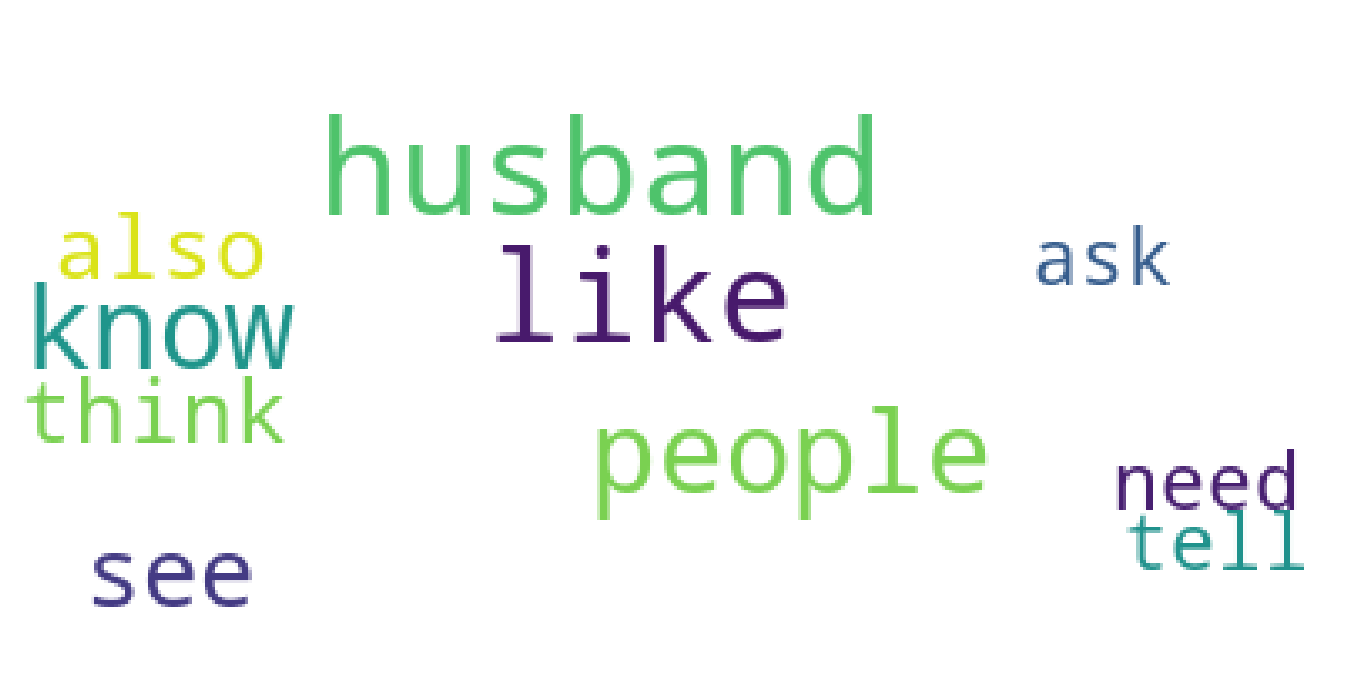

In [234]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=com_stop_words,
                          max_words=10,
                          max_font_size=40, 
                          random_state=4
                         ).generate(str(ali.clean))


fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

           Frequency
Word                
like             216
know             100
see               48
baby              42
day               35
time              35
husband           35
people            31
man               31
right             30
tell              29
think             27
look              26
need              25
give              22
god               22
every             21
try               21
feel              21
take              20
eat               20
much              19
first             19
back              19
work              19
pussy             19
one               19
pregnant          18
say               18
well              17
good              17
asian             17
dude              17
yes               17
white             15
leave             15
want              15
old               15
never             14
turn              14
use               13
life              13
keep              13
dick              13
money             13
two          

<AxesSubplot:xlabel='Word'>

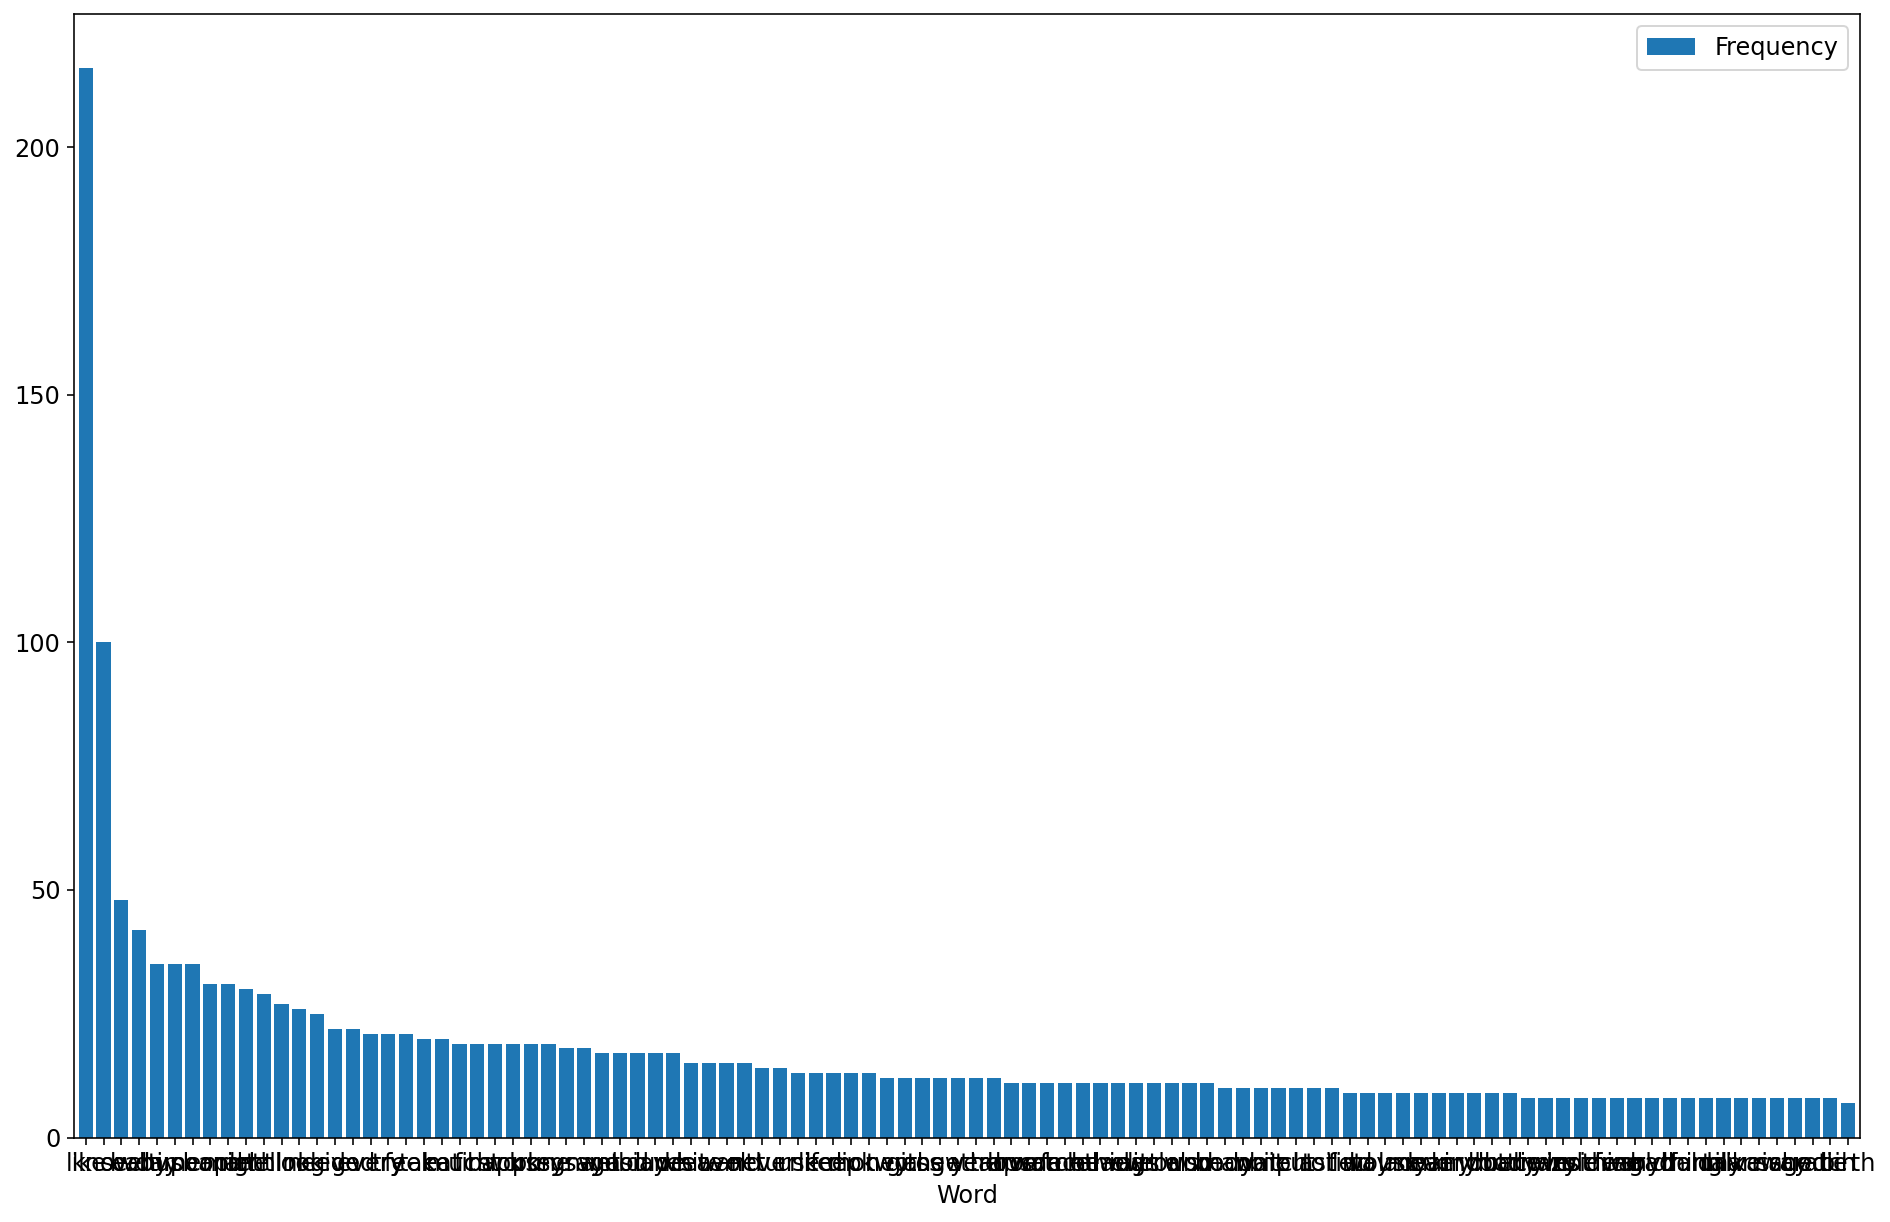

In [235]:
top_N = 100
stopwords = com_stop_words
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (ali.clean
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
rslt = pd.DataFrame(Counter(words).most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
print(rslt)

# plot
rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

In [313]:
cv = CountVectorizer(stop_words=com_stop_words,max_df=.9)
doc_word = cv.fit_transform(aliamy["Text"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [314]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 3)


Topic  0
know, pregnant, want

Topic  1
one, hes, girl

Topic  2
squish, cum, ever

Topic  3
shit, gotta, baby

Topic  4
guys, want, whats


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


### Ali Amy ScatterText

In [227]:
aliamy = ali.append(amy)

In [231]:
corpus = st.CorpusFromPandas(aliamy,
                             category_col='Comedian',
                             text_col='Text',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

In [232]:
html = st.produce_scattertext_explorer(
        corpus,
        category='Ali Wong',
        category_name='Ali Wong',
        not_category_name='Amy Schumer',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=aliamy['Comedian'],
        )

In [233]:
open('ali.html', 'wb').write(html.encode('utf-8'));

I think the scatterText of the word choice is quite interesting, especially when compared with some of the topics coming out of the indivudal modeling of the two comedians. 

In [442]:
aliamy.reset_index(inplace=True)

In [443]:
newstops = ['right','uh','youre','could','w','thank','thing','im','conve','okay','th','pe','dtype','pha','b','ugh','amy','dave','make','lot','come','let','even','yo','went','got','go','ok','ill','hey','nt','ca',"oh", "um",'thank you', 'cause','wan','wa','na','ta','gon','thats','kevin', 'theyre','cant','aint','yeah', 'would','really','get','didnt','dont']
com_stop_words.extend(newstops)

In [444]:
cv = CountVectorizer(stop_words=com_stop_words,max_df = .3,min_df = 2)
doc_word = cv.fit_transform(aliamy["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [445]:
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 10)


Topic  0
day, baby, time, tell, husband, good, take, pregnant, kind, work

Topic  1
want, man, feel, love, god, sex, head, talk, back, ever

Topic  2
guy, girl, never, date, way, try, meet, talk, mean, good


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [446]:
doc_topics_df = pd.DataFrame(doc_topic)
doc_topics_df = doc_topics_df.rename(columns={0: "Family/Home", 1: "Dating", 2:"Sex"})
doc_topics_df

,Family/Home,Dating,Sex
0,0.460,1.762e-01,0.044
1,0.294,3.352e-02,0.000
2,0.678,0.000e+00,0.000
3,0.206,1.891e-04,0.024
4,0.148,3.986e-01,0.000
...,...,...,...
205,0.395,4.775e-01,0.000
206,0.198,2.210e-01,0.149
207,0.105,3.601e-01,0.170
208,0.213,9.348e-01,0.000


In [456]:
aliamy = aliamy.merge(doc_topics_df, how='left', right_index=True,left_index=True)

In [459]:
a1 = (aliamy.groupby(['Comedian'], as_index=False).mean()
            .groupby('Comedian')[['Dating','Sex','Family/Home']].mean())
a1

,Dating,Sex,Family/Home
Comedian,,,
Ali Wong,0.181,0.057,0.334
Amy Schumer,0.256,0.257,0.179


So Ali tends to talk more about family life where as Amy talks alot more about sex,  This was pretty clear from the Scatter Text as well, with Amy's terms around sex being a bit more derogatory

### Comedy Recommender

Next we will build a similarity matrix to try and find specials with similar content to a given stand up. We will start with the concept of putting in a joke or a particular section of a comedy and see how it relates to other sections of text from another comedy.  We will use TF-IDF on the whole cleaned text.

In [239]:
tfidf = TfidfVectorizer(stop_words=com_stop_words)

#Construct the required TF-IDF matrix by applying the fit_transform method on the overview feature
overview_matrix = tfidf.fit_transform(comedy['clean'])
#Output the shape of tfidf_matrix
overview_matrix.shape


(1385, 6394)

In [240]:
similarity_matrix = linear_kernel(overview_matrix,overview_matrix)
similarity_matrix

array([[1.        , 0.20694061, 0.07049577, ..., 0.06113672, 0.04792592,
        0.02742002],
       [0.20694061, 1.        , 0.11381919, ..., 0.03159514, 0.15854971,
        0.03302014],
       [0.07049577, 0.11381919, 1.        , ..., 0.02287434, 0.03682576,
        0.02282877],
       ...,
       [0.06113672, 0.03159514, 0.02287434, ..., 1.        , 0.08788234,
        0.05438825],
       [0.04792592, 0.15854971, 0.03682576, ..., 0.08788234, 1.        ,
        0.1370684 ],
       [0.02742002, 0.03302014, 0.02282877, ..., 0.05438825, 0.1370684 ,
        1.        ]])

In [265]:
comedy_rec = comedy.copy()

In [266]:
comedy_rec['Section'] = comedy_rec['Section'].astype(str)

In [267]:
comedy_rec['com_title_sec'] = jon["Comedian"] + " " + jon["Title"] + " " + jon['Section']

In [270]:
mapping = pd.Series(jon.index,index = comedy_rec['com_title_sec'])
mapping

com_title_sec
Dave Chappelle Killin' Them Softly 1       0
Dave Chappelle Killin' Them Softly 2       1
Dave Chappelle Killin' Them Softly 3       2
Dave Chappelle Killin' Them Softly 4       3
Dave Chappelle Killin' Them Softly 5       4
                                        ... 
Louis CK Sincerely 58                   1380
Louis CK Sincerely 59                   1381
Louis CK Sincerely 60                   1382
Louis CK Sincerely 61                   1383
Louis CK Sincerely 62                   1384
Length: 1385, dtype: int64

In [295]:
def comedy_recco(com_input):
    com_index = mapping[com_input]
    #get similarity values with other stand ups
    #similarity_score is the list of index and similarity matrix
    similarity_score = list(enumerate(similarity_matrix[com_index]))
    #sort in descending order the similarity score of comedy specials inputted with all the other specials
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    # Get the scores of the 3 most similar movies. Ignore the first as it will match the same artist
    similarity_score = similarity_score[1:4]
    #return comedian, special and section of special using the mapping series
    com_indices = [i[0] for i in similarity_score]
    return print((comedy_rec[['Comedian']].iloc[com_indices]))

In [285]:
comedy_recco('Ali Wong Baby Cobra 10')

,Comedian,Title,Section
1198,Iliza Shlesinger,Unveiled,2
640,Kevin Hart,Irresponsible,8
1369,Louis CK,Sincerely,47


While this isn't perfect its a step in the right direction of creating similar comedy (on word basis).  Ideally we'd look at whole comedy's not just similar sections and ideally we'd be using topic modeling than using a specific block of text/story/joke to find it.  I'd like to add more comedy to the database to build up more robust topics before proceeding with this further

Let's Loop thru ali's two stand up specials and look at what Comedians appear the most.

In [296]:
for i in range (1,39):
    print(comedy_recco('Ali Wong Baby Cobra ' + str(i)))

              Comedian
1197  Iliza Shlesinger
422        Amy Schumer
801          Bill Burr
None
        Comedian
461  Amy Schumer
352  Amy Schumer
632  Wanda Sykes
None
           Comedian
905    Emily Heller
498        Ali Wong
204  Dave Chappelle
None
             Comedian
1006    Ricky Gervais
1177  Ellen Degeneres
698        Kevin Hart
None
        Comedian
1107  Jimmy Yang
1108  Jimmy Yang
1106  Jimmy Yang
None
              Comedian
1380          Louis CK
1197  Iliza Shlesinger
711         Kevin Hart
None
        Comedian
532     Ali Wong
482     Ali Wong
353  Amy Schumer
None
        Comedian
617  Wanda Sykes
869    Bill Burr
377  Amy Schumer
None
           Comedian
805       Bill Burr
782   Amanda Seales
124  Dave Chappelle
None
              Comedian
1198  Iliza Shlesinger
640         Kevin Hart
1369          Louis CK
None
         Comedian
1362     Louis CK
333   Amy Schumer
348   Amy Schumer
None
            Comedian
1340        Louis CK
412      Amy Schumer
298   Dave Cha

In [472]:
for i in range (1,39):
    print(comedy_recco('Ali Wong Hard Knock Wife ' + str(i)))

        Comedian
655   Kevin Hart
652   Kevin Hart
1363    Louis CK
None
        Comedian
655   Kevin Hart
652   Kevin Hart
1065  Chris Rock
None
        Comedian
652   Kevin Hart
655   Kevin Hart
1364    Louis CK
None
         Comedian
897  Emily Heller
470      Ali Wong
337   Amy Schumer
None
     Comedian
467  Ali Wong
469  Ali Wong
462  Ali Wong
None
       Comedian
466    Ali Wong
652  Kevin Hart
649  Kevin Hart
None
        Comedian
376  Amy Schumer
615  Wanda Sykes
469     Ali Wong
None
           Comedian
93   Dave Chappelle
83   Dave Chappelle
466        Ali Wong
None
       Comedian
655  Kevin Hart
465    Ali Wong
475    Ali Wong
None
            Comedian
360      Amy Schumer
622      Wanda Sykes
569  Sarah Silverman
None
           Comedian
99   Dave Chappelle
199  Dave Chappelle
100  Dave Chappelle
None
            Comedian
648       Kevin Hart
551  Sarah Silverman
211   Dave Chappelle
None
           Comedian
377     Amy Schumer
95   Dave Chappelle
374     Amy Schumer
None

KeyError: 'Ali Wong Hard Knock Wife 33'

### Dave Chapelle 

In [469]:
dave = comedy[comedy["Comedian"] == "Dave Chappelle"]

In [470]:
dave = dave.sort_values(by=['Year','Section'])
dave.reset_index(inplace=True, drop=True)

In [471]:
dave

,Year,Title,Comedian,Location,Comedian_Gender,Ovr_Rating,Median_Rating,Tot_Review,Female_Rating,Male_Rating,Female_Review,Male_Review,Section,Text,nltk,clean
0,1998,HBO Comedy Special,Dave Chappelle,"San Francisco, CA",M,8.2,8.0,195,7.9,8.2,11,149,1,thank you thank you all thank you whats up san...,thank you thank you all thank you whats up san...,thank you thank you all thank you what s up sa...
1,1998,HBO Comedy Special,Dave Chappelle,"San Francisco, CA",M,8.2,8.0,195,7.9,8.2,11,149,2,dont deal with jails and i dont deal with poli...,dont deal with and i dont deal with police my ...,do nt deal with and I do nt deal with police m...
2,1998,HBO Comedy Special,Dave Chappelle,"San Francisco, CA",M,8.2,8.0,195,7.9,8.2,11,149,3,hi im here to bail out my buddy oh okay well w...,hi here to bail out my buddy oh well while her...,hi here to bail out my buddy oh well while her...
3,1998,HBO Comedy Special,Dave Chappelle,"San Francisco, CA",M,8.2,8.0,195,7.9,8.2,11,149,4,criminals are insane i dont even know why peop...,are insane i dont even know why people do crim...,be insane I do nt even know why people do crim...
4,1998,HBO Comedy Special,Dave Chappelle,"San Francisco, CA",M,8.2,8.0,195,7.9,8.2,11,149,5,ts amazing i saw them get a dude one time on c...,amazing i saw them get a dude one time on cour...,amazing I see they get a dude one time on cour...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,2019,Sticks & Stones,Dave Chappelle,"Atlanta, GA",M,8.5,9.0,22204,8.1,8.4,1400,13912,32,im just afraid of being attacked it happens to...,just afraid of being it to the best of us dont...,just afraid of be it to the good of we do nt e...
319,2019,Sticks & Stones,Dave Chappelle,"Atlanta, GA",M,8.5,9.0,22204,8.1,8.4,1400,13912,33,black people never feel sorry for the police b...,black people never feel sorry for the police b...,black people never feel sorry for the police b...
320,2019,Sticks & Stones,Dave Chappelle,"Atlanta, GA",M,8.5,9.0,22204,8.1,8.4,1400,13912,34,so okay im doing a show somewhere and im on st...,so doing a show somewhere and on stage and i w...,so do a show somewhere and on stage and I be a...
321,2019,Sticks & Stones,Dave Chappelle,"Atlanta, GA",M,8.5,9.0,22204,8.1,8.4,1400,13912,35,if if youre in a group that i made fun of then...,if if in a group that i made fun of then just ...,if if in a group that I make fun of then just ...


In [498]:
cv = CountVectorizer(stop_words=com_stop_words,max_df=.8)
doc_word = cv.fit_transform(dave["clean"])
clean_feat = pd.DataFrame(doc_word.toarray(),columns=cv.get_feature_names())

In [499]:
nmf_model = NMF(3)
doc_topic = nmf_model.fit_transform(clean_feat)

display_topics(nmf_model, cv.get_feature_names(), 10)


Topic  0
like, man, talk, see, time, pussy, guy, tell, feel, one

Topic  1
say, know, like, one, show, good, david, gay, want, mean

Topic  2
know, people, see, white, think, black, mean, man, time, good


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
